In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [41]:
!pip install scikit-learn==1.5.0 scikeras==0.13.0

In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasRegressor, KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Regression

### Load Dataset

In [43]:
# Load dataset
dataset = '/content/drive/My Drive/energy_efficiency_data.csv'
df = pd.read_csv(dataset)

# Show first rows
print(df.head())
print(df.columns)

   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   Cooling_Load  
0         21.33  
1         21.33  
2         21.33  
3         21.3

### Data Preprocessing

In [44]:
# Features and target
X = df.iloc[:, :-2]
y = df['Heating_Load']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale inputs and targets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (614, 8)
Test shape: (154, 8)


Preprocessing includes separating the features and the target column "Heating_Load", splitting the data into training and test sets, scaling the input features to ensure similar ranges, and scaling the target values to improve model learning.

### Baseline Model: Linear Regression

In [45]:
# Linear Regression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

The Linear Regression model was trained using the training data. It was then tested on the test set. Its performance was evaluated using MSE, MAE, and R² score to measure how well it predicted the heating load.


### Deep Learning Model: Fully Connected NN

In [46]:
# Model builder function expects scaled targets
def build_model(units=32, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Wrap model for sklearn
keras_reg = KerasRegressor(model=build_model, verbose=0)

# Hyperparameter grid
param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Grid search with 3-fold CV on scaled targets
grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid,
                    cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit grid search with scaled targets
grid_result = grid.fit(X_train_scaled, y_train_scaled)

print("Best parameters:", grid_result.best_params_)
print(f"Best CV MSE: {-grid_result.best_score_:.4f}")

# Evaluate on test set
best_model = grid_result.best_estimator_

# Predict scaled outputs on test set
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__units': 64}
Best CV MSE: 0.0369


The deep learning model was trained to predict the heating load using scaled input and target values to improve learning efficiency. A neural network with multiple dense layers and dropout was used to reduce overfitting. A grid search with cross-validation was applied to find the best hyperparameters. After training, predictions were made on the scaled test data and then inverse transformed back to the original scale. The model's performance was evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score.

### Compare Baseline vs. Deep Learning

In [47]:
print("Baseline Linear Regression:")
print(f"MSE: {mean_squared_error(y_test, y_pred_baseline):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_baseline):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_baseline):.4f}")

print("\nDeep Learning Model:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

Baseline Linear Regression:
MSE: 9.1517
MAE: 2.1825
R2 Score: 0.9122

Deep Learning Model:
MSE: 1.6548
MAE: 1.0175
R2 Score: 0.9841


The Deep Learning model gave better results than the Linear Regression model for predicting heating load. It made more accurate predictions, with smaller errors (lower MSE and MAE). It also had a higher R² score, which means it explained the data better. Overall, the Deep Learning model was more reliable and accurate.

Best parameters: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__units': 64}
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - loss: 1.1022 - mae: 0.9057 - val_loss: 0.2631 - val_mae: 0.3759
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3815 - mae: 0.4734 - val_loss: 0.1401 - val_mae: 0.2608
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2069 - mae: 0.3463 - val_loss: 0.1064 - val_mae: 0.2304
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2210 - mae: 0.3630 - val_loss: 0.1009 - val_mae: 0.2161
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1795 - mae: 0.3293 - val_loss: 0.0978 - val_mae: 0.2205
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1608 - mae: 0.3072 - val_loss: 0.0920 - val_mae: 0.2109
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1521 - mae: 0.2953 - val_loss: 0.0866 - val_mae: 0.2071
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1528 - mae: 0.29

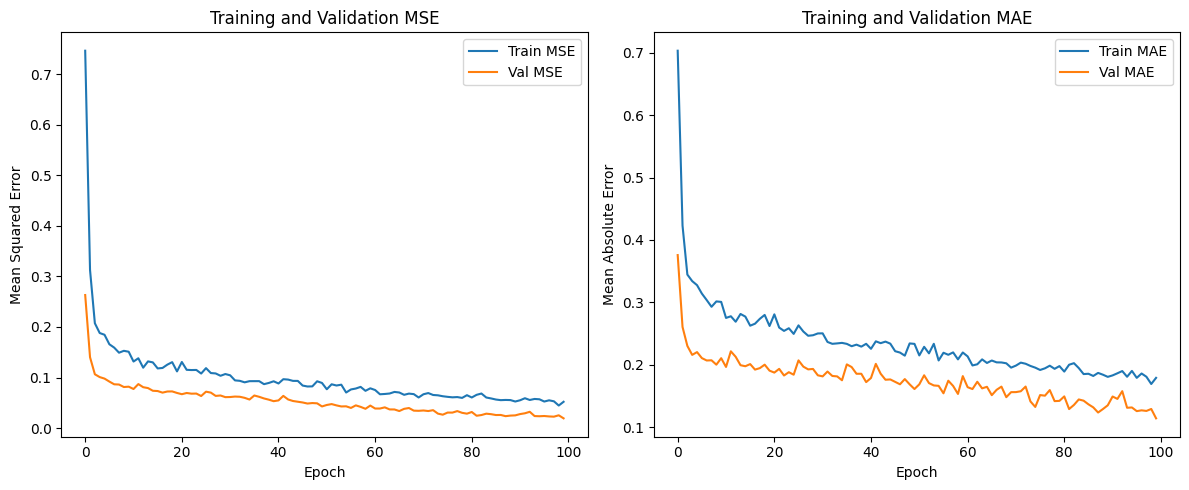

In [48]:
best_params = grid_result.best_params_
print("Best parameters:", best_params)

# Extract best hyperparameters (with correct keys)
best_units = best_params['model__units']
best_dropout = best_params['model__dropout_rate']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']

# Build model with best hyperparameters
model = build_model(units=best_units, dropout_rate=best_dropout)

# Fit model on scaled targets
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=best_epochs,
    batch_size=best_batch_size,
    verbose=1
)

# Plot training and validation MSE and MAE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

*   Training loss starts at ~0.76 and decreases to ~0.05.
*   Validation loss starts at ~0.22 and decreases to ~0.0245.
*   Both training and validation loss are decreasing steadily without big jumps or spikes.
*   Validation loss is close to training loss, no big gap (means no overfitting).
*   This means model is converging well on the dataset.

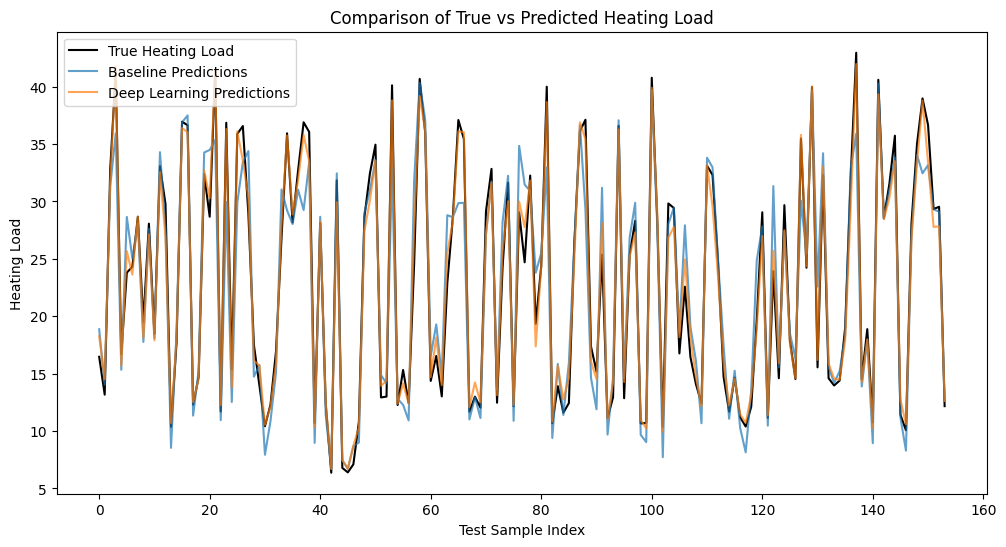

In [49]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='True Heating Load', color='black')
plt.plot(y_pred_baseline, label='Baseline Predictions', alpha=0.7)
plt.plot(y_pred, label='Deep Learning Predictions', alpha=0.7)

plt.title('Comparison of True vs Predicted Heating Load')
plt.xlabel('Test Sample Index')
plt.ylabel('Heating Load')
plt.legend()
plt.show()

This plot compares the true heating load values with predictions from both the baseline (Linear Regression) and Deep Learning models. It shows how closely each model's predictions match the actual values. The Deep Learning line is generally closer to the true values, indicating better performance.

# Classification

### Load Dataset

In [50]:
# Load dataset
file_path = '/content/drive/My Drive/creditcard.csv'
df = pd.read_csv(file_path)

# Show first rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [51]:
print(df.info())
print(df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Data Preprocessing

In [52]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Scale features (all features or only specific columns consistently)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Train shape: (227845, 30)
Test shape: (56962, 30)
X_train_scaled shape: (227845, 30)
X_test_scaled shape: (56962, 30)
y_train shape: (227845,)
y_test shape: (56962,)


In preprocessing, the features and the target column "Class" were separated. All features were scaled using standard scaling. Then, the data was split into training and test sets using stratified sampling to keep the class balance the same in both sets.

### Baseline Model: Logistic Regression

In [53]:
# Logistic Regression with class weights to balance the dataset
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit the model on training data
logreg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lr = logreg.predict(X_test_scaled)
y_pred_lr_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # for ROC-AUC

# Evaluation
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr_proba))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC-AUC (Logistic Regression): 0.9720834996210077


The Logistic Regression model was trained using class weights to handle the imbalance between normal and fraud transactions. It was then used to predict on the test data. The model's performance was evaluated using a classification report, which showed that although it had low precision for fraud cases, it achieved high recall—correctly identifying most frauds. The overall accuracy was high, mainly due to the large number of non-fraud cases.

### Deep Learning Model: Fully Connected NN

In [54]:
class F1ScoreCallback(Callback):
    def __init__(self, training_data, validation_data):
        super().__init__()
        self.X_train, self.y_train = training_data
        self.X_val, self.y_val = validation_data
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred_probs = self.model.predict(self.X_train, verbose=0).flatten()
        y_train_pred = (y_train_pred_probs > 0.5).astype(int)
        train_f1 = f1_score(self.y_train, y_train_pred)
        self.train_f1_scores.append(train_f1)

        y_val_pred_probs = self.model.predict(self.X_val, verbose=0).flatten()
        y_val_pred = (y_val_pred_probs > 0.5).astype(int)
        val_f1 = f1_score(self.y_val, y_val_pred)
        self.val_f1_scores.append(val_f1)

        print(f" — train_f1: {train_f1:.4f} — val_f1: {val_f1:.4f}")

# 2) Create a new instance
f1_callback = F1ScoreCallback(training_data=(X_train_scaled, y_train),
                             validation_data=(X_test_scaled, y_test))


In [55]:
# Manually set class weights: smaller weight for fraud class
class_weight_dict = {
    0: 0.5,
    1: 75.0
}
print("Using class weights:", class_weight_dict)

# Build model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# Train model
f1_callback = F1ScoreCallback(training_data=(X_train_scaled, y_train),
                             validation_data=(X_test_scaled, y_test))

history = model.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[f1_callback],
    class_weight=class_weight_dict,
    verbose=2
)

Using class weights: {0: 0.5, 1: 75.0}
Epoch 1/10
 — train_f1: 0.4021 — val_f1: 0.3723
7121/7121 - 51s - 7ms/step - accuracy: 0.9920 - loss: 0.1328 - recall: 0.7437 - val_accuracy: 0.9949 - val_loss: 0.0394 - val_recall: 0.8776
Epoch 2/10
 — train_f1: 0.5099 — val_f1: 0.4831
7121/7121 - 72s - 10ms/step - accuracy: 0.9942 - loss: 0.0721 - recall: 0.8655 - val_accuracy: 0.9968 - val_loss: 0.0261 - val_recall: 0.8776
Epoch 3/10
 — train_f1: 0.4074 — val_f1: 0.3902
7121/7121 - 39s - 5ms/step - accuracy: 0.9957 - loss: 0.0672 - recall: 0.8782 - val_accuracy: 0.9952 - val_loss: 0.0382 - val_recall: 0.8980
Epoch 4/10
 — train_f1: 0.5964 — val_f1: 0.5519
7121/7121 - 51s - 7ms/step - accuracy: 0.9951 - loss: 0.0597 - recall: 0.8883 - val_accuracy: 0.9976 - val_loss: 0.0311 - val_recall: 0.8673
Epoch 5/10
 — train_f1: 0.6054 — val_f1: 0.5763
7121/7121 - 37s - 5ms/step - accuracy: 0.9946 - loss: 0.0581 - recall: 0.8959 - val_accuracy: 0.9978 - val_loss: 0.0166 - val_recall: 0.8673
Epoch 6/10
 — t

The model trains for 10 epochs with high accuracy and improving recall, but F1 scores vary. It’s learning well but may need tuning for better balance between precision and recall.

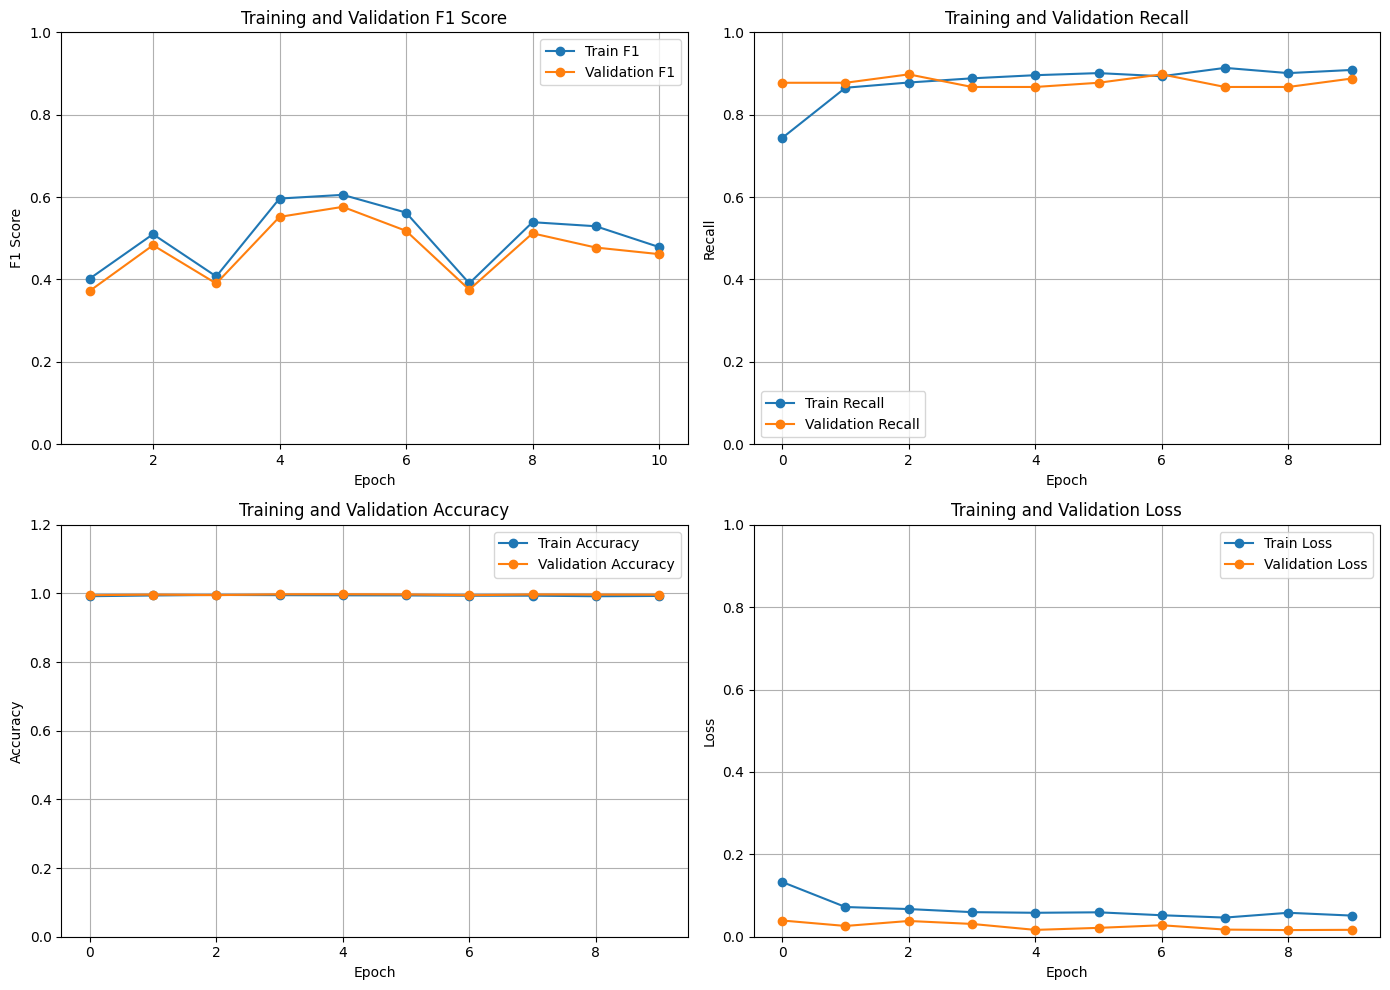

In [61]:
plt.figure(figsize=(14, 10))

# F1-score plot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(f1_callback.train_f1_scores) + 1), f1_callback.train_f1_scores, marker='o', label='Train F1')
plt.plot(range(1, len(f1_callback.val_f1_scores) + 1), f1_callback.val_f1_scores, marker='o', label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Recall plot
plt.subplot(2, 2, 2)
plt.plot(history.history['recall'], marker='o', label='Train Recall')
plt.plot(history.history['val_recall'], marker='o', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This set of plots shows how the model performed over each training epoch. The F1 score, recall, and accuracy generally improve or stay stable, indicating the model is learning well on both training and validation data. The loss decreases steadily, meaning the model is minimizing errors. Overall, the training and validation curves are close, suggesting the model is not overfitting much and is learning effectively.

In [56]:
# Predict probabilities on test set

y_pred_probs = model.predict(X_test_scaled, verbose=0).flatten()

# Precision-Recall curve and threshold tuning

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

target_recall = 0.85
best_threshold = 0.5
best_precision = 0

# Find threshold with recall >= target_recall and highest precision
for p, r, t in zip(precisions, recalls, np.append(thresholds, 1)):
    if r >= target_recall and p > best_precision:
        best_precision = p
        best_threshold = t

print(f"Selected threshold: {best_threshold:.3f} with precision: {best_precision:.3f} and recall >= {target_recall}")

# Apply tuned threshold
y_pred_tuned = (y_pred_probs >= best_threshold).astype(int)

Selected threshold: 0.838 with precision: 0.618 and recall >= 0.85


###  Evaluation Reports Before and After Threshold Tuning (Deep Learning)

In [57]:
# Default threshold (0.5) predictions and evaluation
y_pred_default = (y_pred_probs >= 0.5).astype(int)

print("\nClassification Report (Default threshold = 0.5):")
print(classification_report(y_test, y_pred_default))

print("Confusion Matrix (Default threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_default))

# Tuned threshold predictions and evaluation
print("\nClassification Report (Tuned threshold):")
print(classification_report(y_test, y_pred_tuned))

print("Confusion Matrix (Tuned threshold):")
print(confusion_matrix(y_test, y_pred_tuned))


Classification Report (Default threshold = 0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.89      0.46        98

    accuracy                           1.00     56962
   macro avg       0.66      0.94      0.73     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix (Default threshold = 0.5):
[[56672   192]
 [   11    87]]

Classification Report (Tuned threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.86      0.72        98

    accuracy                           1.00     56962
   macro avg       0.81      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix (Tuned threshold):
[[56812    52]
 [   14    84]]


### Compare Baseline vs. Deep Learning

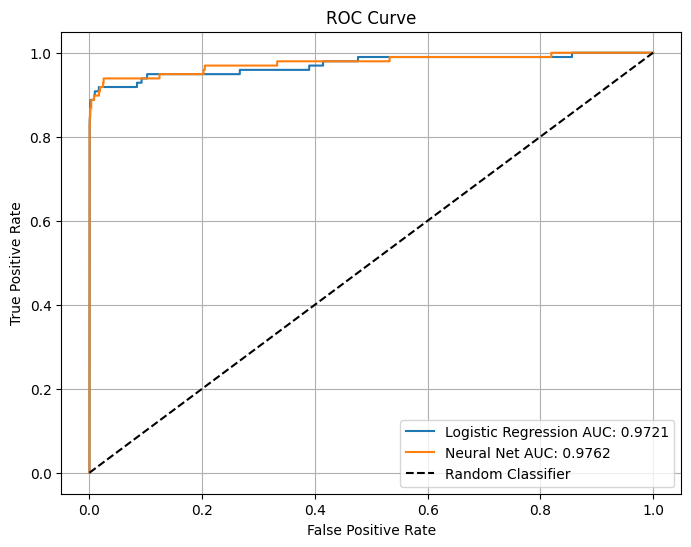

In [59]:
# Plot ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression AUC: {auc(fpr_lr, tpr_lr):.4f}")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Net AUC: {auc(fpr_nn, tpr_nn):.4f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

This plot shows how well the Logistic Regression and Neural Network models can tell apart fraud and normal transactions. The curve shows the balance between catching frauds (true positives) and wrongly flagging normal ones (false positives). The bigger the area under the curve (AUC), the better the model is.

#### Confusion Matrix

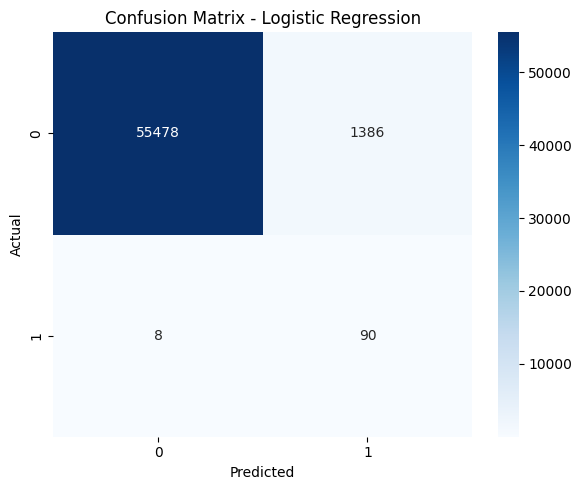

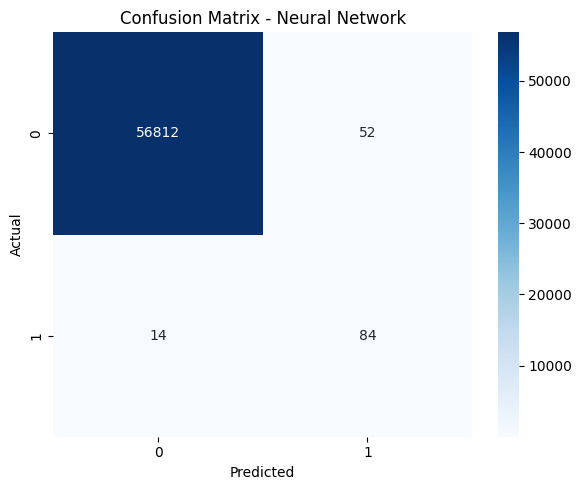

In [60]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion matrix for Neural Network (tuned threshold)
cm_dl = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()